## This script takes in collated data from pyGluCEST (summer 2024 version with nmaps and lots of atlases)

In [140]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Functions

In [141]:
# Filter df:
def column_to_keep2(column_name, subj_info, parcels):
    if column_name in subj_info:
        return True
    for num in parcels:
        if num in column_name:
            return True
    return False

def column_to_keep(column_name, subj_info, parcels):
    # If the column is in subject info, keep it
    if column_name in subj_info:
        return True
    # Check if any parcel number exists as a substring in the column name
    return any(parcel in column_name for parcel in parcels)




### Define paths and variables

In [ ]:
# Make dictionary with number of parcels for each atlas

desikan-killiany
destrieux2009_rois_UNI.csv
HarvardOxford-cort-maxprob-thr25_UNI.csv
HarvardOxford-sub-maxprob-thr25_UNI.csv
Schaefer2018_1000Parcels_17Networks_UNI.csv
Schaefer2018_1000Parcels_7Networks_UNI.csv
Schaefer2018_100Parcels_17Networks_UNI.csv
Schaefer2018_100Parcels_7Networks_UNI.csv
Schaefer2018_400Parcels_17Networks_UNI.csv
Schaefer2018_400Parcels_7Networks_UNI.csv


Subject	group	7Networks_LH_Vis_5 NZMean	7Networks_LH_Vis_5 NZcount	7Networks_LH_Vis_5 NZSigma	7Networks_LH_Vis_6 NZMean	7Networks_LH_Vis_6 NZcounte

In [147]:
# Choose what to analyse
cohort = "longglucest_outputmeasures2"
atlas = "HarvardOxford-cort-maxprob-thr25"
nmaps = ["mGluR5", "NMDA", "GABA"]

# Set paths
root = "/Users/pecsok/Desktop/ImageData/PMACS_remote/data/nmaps/" + cohort 
outpath = "/Users/pecsok/Desktop/ImageData/PMACS_remote/data/nmaps/analyses/" + atlas + "/" + cohort 
figpath = "/Users/pecsok/Desktop/ImageData/PMACS_remote/data/nmaps/analyses/" + atlas + "/" + cohort + "/figures"
os.makedirs('outpath', exist_ok=True)
os.makedirs('figpath', exist_ok=True)

# Read in the cest data and compile
cestdata = pd.read_csv(root + "/all_subs_GluCEST_" + atlas + "_UNI.csv", sep=',')
grp_df = cestdata # Build group dataframe from cest data



In [ ]:
## Filter GluCEST dataset

In [148]:
# Exclude parcels with fewer than 20 voxels of data
for col in grp_df.columns:
    if col.endswith('NZcount'):
        mean_col = col.replace('NZcount', 'NZMean')
        grp_df.loc[grp_df[col] < 20, mean_col] = np.nan
        
# Include only parcels that have enough data.
columns = grp_df.columns[grp_df.notnull().sum() > len(grp_df)*.75]
parcels = [col.split(' ')[0] for col in columns if ' ' in col]
subj_info = ["Subject", "group"]   
filtered_grp_cols = [col for col in grp_df.columns if column_to_keep(col, subj_info, parcels)]
grp_df = grp_df[filtered_grp_cols]

# Filter out sigma columns and add datatype column
grp_df = grp_df.filter(regex='Subject|group|NZMean|count')
grp_df.loc[:, 'datatype'] = 'CEST'
#grp_df.set_index(['Subject','group'], inplace=True)

In [149]:
# Read in and reformat nmap data, then append to GluCEST df.
nmap_dfs = {}
for nmap in nmaps: 
    print(nmap)
    nmapdata = pd.read_csv(root + "/all_subs_" + nmap + "_normalized_" + atlas + "_UNI.csv", sep=',') #import
    filtered_nmap_cols = [col for col in nmapdata.columns if column_to_keep(col, subj_info, parcels)]
    nmapdata = nmapdata[filtered_nmap_cols]
    nmapdata = nmapdata.filter(regex='Subject|group|NZMean|count')
    nmapdata.loc[:, 'datatype'] = nmap
    #nmapdata.set_index(['Subject','group'], inplace=True)
    nmap_dfs[nmap] = nmapdata

    #grp_df = pd.concat([grp_df, nmapdata], axis=0)

mGluR5
NMDA
GABA


In [100]:
#grp_df.columns


In [ ]:
### NEW SCRIPT

mGluR5


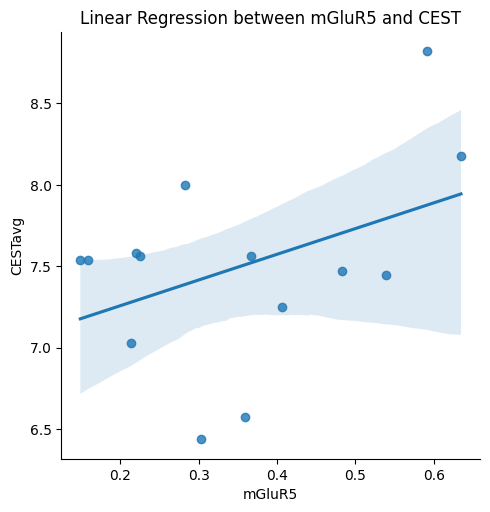

mGluR5  All participants Pearson
r=0.4170297887134945  p=0.137945533438248
NMDA


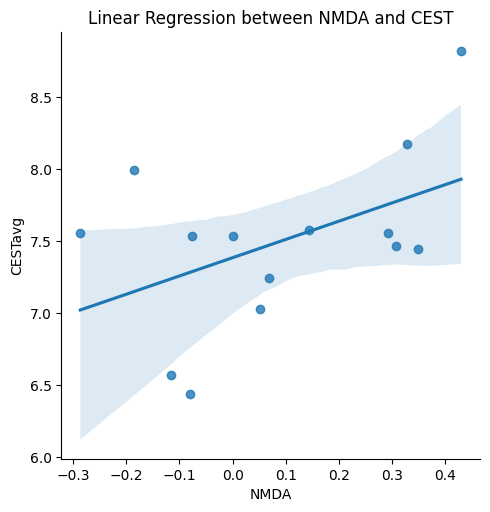

NMDA  All participants Pearson
r=0.4719074685329665  p=0.08844278474939843
GABA


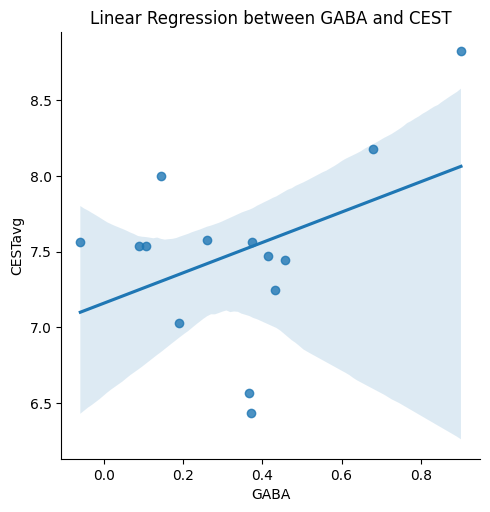

GABA  All participants Pearson
r=0.41225668301356444  p=0.14297631493462945


In [154]:
from scipy.stats import spearmanr

nmap_palette = {
    "NMDA": "Purples",   # Replace with actual nmap names and desired palettes
    "mGluR5": "Reds",
    "GABA": "Greens",
    "D2": "Oranges"}

for nmap in nmaps:
    nmap_df = nmap_dfs[nmap]
    print(nmap)
    
    # Step 1: Calculate the average value for each brain region across subjects
    means_nmap = nmap_df.filter(regex='NZMean')
    mean_nmap = means_nmap.mean(axis=0)  # Compute mean for each column (region) across subjects (rows)

    means_cest = grp_df.filter(regex='NZMean')
    mean_cest = means_cest.mean(axis=0)  # Compute mean for each column (region) across subjects (rows)

    combined_means_df = pd.DataFrame({
    'Average Glutamate': mean_cest,   # Column for Glutamate (mean_cest)
    'Average nmap': mean_nmap         # Column for nmap (mean_nmap)
    })

    combined_means_df = combined_means_df[combined_means_df['Average Glutamate'] < 9]
    combined_means_df = combined_means_df[combined_means_df['Average Glutamate'] > 6]
    
    palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
    plot = sns.lmplot(x='Average nmap', y='Average Glutamate', data = combined_means_df, palette=palette)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show()
    
    rval, pval = pearsonr(combined_means_df['Average nmap'],combined_means_df["Average Glutamate"])
    print(nmap + "  All participants Pearson")
    print("r=" + str(rval)," p=" + str(pval))


mGluR5
Brain-Stem NZMean                         7.887885
CSF NZMean                                5.185464
Right-Cerebral-White-Matter NZMean        6.278530
Right-Lateral-Ventricle NZMean            4.897006
Right-Cerebellum-White-Matter NZMean      8.574710
Right-Cerebellum-Cortex NZMean            9.614132
Right-Thalamus-Proper NZMean              7.434421
Right-Caudate NZMean                      6.768146
Right-Accumbens-area NZMean               7.681865
Right-VentralDC NZMean                    7.147968
Right-choroid-plexus NZMean               5.235858
ctx-rh-unknown NZMean                     7.504316
ctx-rh-caudalanteriorcingulate NZMean     7.551913
ctx-rh-cuneus NZMean                      9.077035
ctx-rh-lingual NZMean                     9.542990
ctx-rh-medialorbitofrontal NZMean         6.771239
ctx-rh-posteriorcingulate NZMean          7.993105
ctx-rh-rostralanteriorcingulate NZMean    6.623938
ctx-rh-superiorfrontal NZMean             7.232366
ctx-rh-frontalpole NZMea

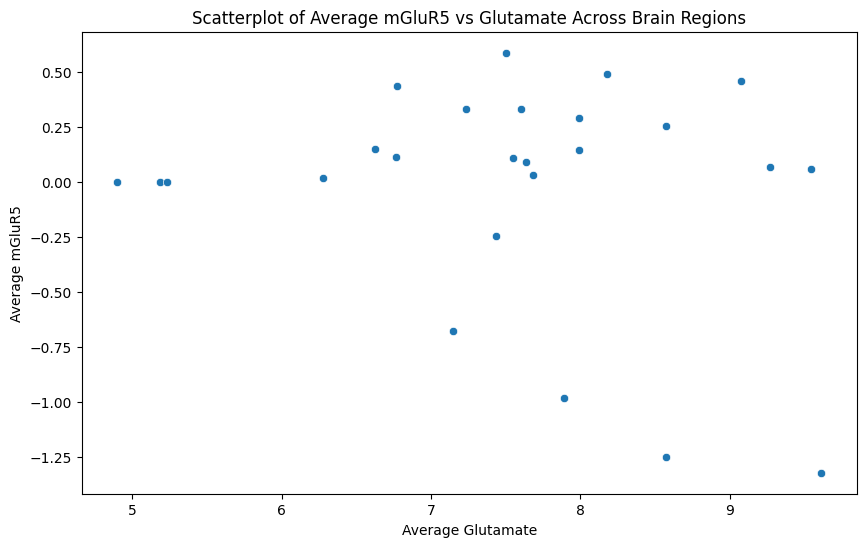

NMDA
Brain-Stem NZMean                         7.887885
CSF NZMean                                5.185464
Right-Cerebral-White-Matter NZMean        6.278530
Right-Lateral-Ventricle NZMean            4.897006
Right-Cerebellum-White-Matter NZMean      8.574710
Right-Cerebellum-Cortex NZMean            9.614132
Right-Thalamus-Proper NZMean              7.434421
Right-Caudate NZMean                      6.768146
Right-Accumbens-area NZMean               7.681865
Right-VentralDC NZMean                    7.147968
Right-choroid-plexus NZMean               5.235858
ctx-rh-unknown NZMean                     7.504316
ctx-rh-caudalanteriorcingulate NZMean     7.551913
ctx-rh-cuneus NZMean                      9.077035
ctx-rh-lingual NZMean                     9.542990
ctx-rh-medialorbitofrontal NZMean         6.771239
ctx-rh-posteriorcingulate NZMean          7.993105
ctx-rh-rostralanteriorcingulate NZMean    6.623938
ctx-rh-superiorfrontal NZMean             7.232366
ctx-rh-frontalpole NZMean 

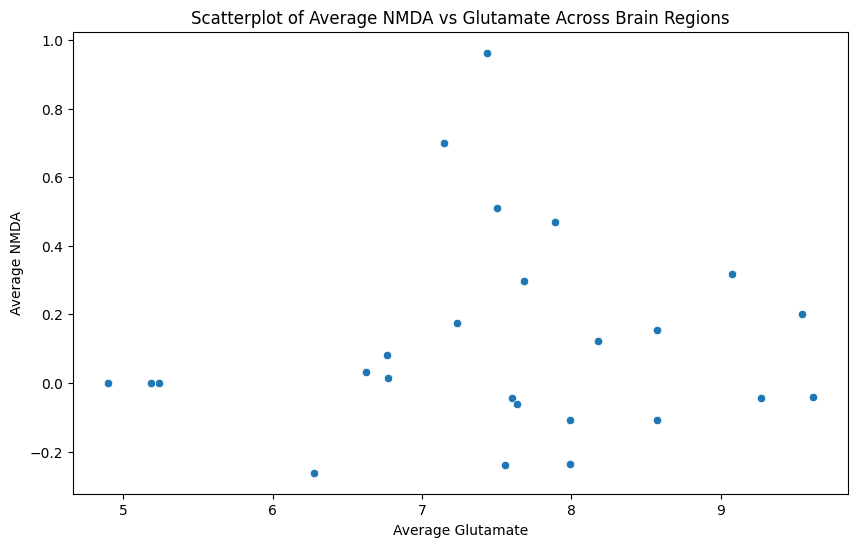

GABA
Brain-Stem NZMean                         7.887885
CSF NZMean                                5.185464
Right-Cerebral-White-Matter NZMean        6.278530
Right-Lateral-Ventricle NZMean            4.897006
Right-Cerebellum-White-Matter NZMean      8.574710
Right-Cerebellum-Cortex NZMean            9.614132
Right-Thalamus-Proper NZMean              7.434421
Right-Caudate NZMean                      6.768146
Right-Accumbens-area NZMean               7.681865
Right-VentralDC NZMean                    7.147968
Right-choroid-plexus NZMean               5.235858
ctx-rh-unknown NZMean                     7.504316
ctx-rh-caudalanteriorcingulate NZMean     7.551913
ctx-rh-cuneus NZMean                      9.077035
ctx-rh-lingual NZMean                     9.542990
ctx-rh-medialorbitofrontal NZMean         6.771239
ctx-rh-posteriorcingulate NZMean          7.993105
ctx-rh-rostralanteriorcingulate NZMean    6.623938
ctx-rh-superiorfrontal NZMean             7.232366
ctx-rh-frontalpole NZMean 

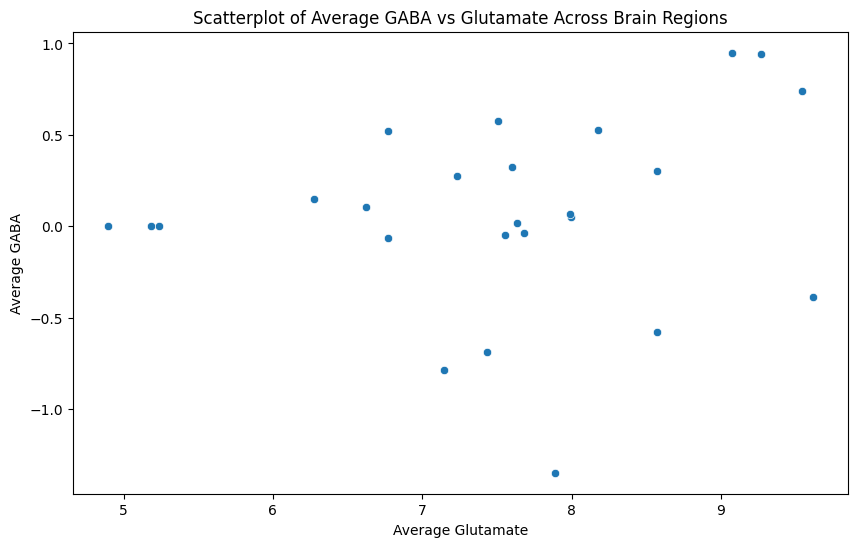

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming grp_df is your first DataFrame (glutamate data) and nmap_df is your second (NMDA data)
# Also assuming that both DataFrames have a 'group' column for subject diagnosis

for nmap in nmaps:
    nmap_df = nmap_dfs[nmap]
    # Step 1: Ensure 'Subject' and 'group' are set as index
    #grp_df.set_index(['Subject', 'group'], inplace=True)
    #nmap_df.set_index(['Subject', 'group'], inplace=True)
    
    # Step 2: Flatten both DataFrames with future_stack=True
    grp_flat = grp_df.stack(dropna=False, future_stack=True).reset_index()
    grp_flat.columns = ['Subject', 'group', 'Region', 'Glutamate']
    
    nmap_flat = nmap_df.stack(dropna=False, future_stack=True).reset_index()
    nmap_flat.columns = ['Subject', 'group', 'Region', nmap]
    
    # Step 3: Merge the flattened DataFrames on 'Subject', 'Region', and 'group'
    merged_df = pd.merge(grp_flat, nmap_flat, on=['Subject', 'group', 'Region'])
    
    # Step 4: Drop any rows with NaN values in either Glutamate or NMDA
    merged_df = merged_df.dropna(subset=['Glutamate', nmap])
    
    # Step 5: Create a scatterplot to correlate regional glutamate with NMDA, color-coded by 'group'
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Glutamate', y='NMDA', hue='group', data=merged_df)
    
    # Step 6: Add titles and labels
    plt.title('Correlation between Regional Glutamate and NMDA')
    plt.xlabel('Glutamate')
    plt.ylabel('NMDA')
    
    # Show the plot
    plt.show()


ValueError: dropna must be unspecified with future_stack=True as the new implementation does not introduce rows of NA values. This argument will be removed in a future version of pandas.

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_47341/1832874202.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  grp_flat = grp_df.stack(dropna=False).reset_index()
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_47341/1832874202.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nmap_flat = nmapdf.stack(dropna=False).reset_index()


TypeError: 'value' must be an instance of str or bytes, not a float

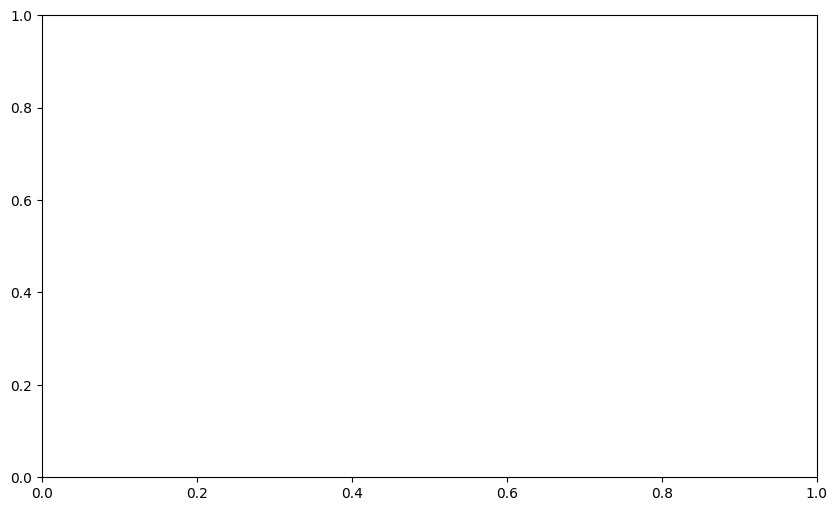

In [86]:
for nmap in nmaps:
    nmapdf = nmap_dfs[nmap]

    grp_flat = grp_df.stack(dropna=False).reset_index()
    grp_flat.columns = ['Subject', 'Region', 'Glutamate']
    
    nmap_flat = nmapdf.stack(dropna=False).reset_index()
    nmap_flat.columns = ['Subject', 'Region', nmap]
    
    # Step 2: Merge the flattened DataFrames on 'Subject' and 'Region'
    merged_df = pd.merge(grp_flat, nmap_flat, on=['Subject', 'Region'])
    merged_df = merged_df.dropna(subset=['Glutamate', nmap])
   #'group', print(merged_df)
    
    # Step 3: Create a scatterplot to correlate regional glutamate with NMDA
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Glutamate', y=nmap, data=merged_df)
    
    # Step 4: Add titles and labels
    plt.title('Correlation between Regional Glutamate and NMDA')
    plt.xlabel('Glutamate')
    plt.ylabel('NMDA')
    
    # Show the plot
    plt.show()
    

In [ ]:
#print(cestdf[CESTavg].max())
from scipy.stats import spearmanr
nmap_palette = {
    "NMDA": "Purples",   # Replace with actual nmap names and desired palettes
    "mGluR5": "Reds",
    "GABA": "Greens",
    "D2": "Oranges"
    # Add more mappings as needed
}

for nmap in nmaps:
    cestdf[nmap] = pd.to_numeric(cestdf[nmap], errors='coerce')
    cestdf['CESTavg'] = pd.to_numeric(cestdf['CESTavg'], errors='coerce')
    plot_data = cestdf.dropna(subset=[nmap, 'CESTavg'])
    palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
    plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus', data=plot_data, palette=palette)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 
    rval, pval = pearsonr(cestdf[nmap],cestdf["CESTavg"])
    print(nmap + "  All participants Pearson")
    print("r=" + str(rval)," p=" + str(pval))
    rval, pval = spearmanr(graphdf[nmap],graphdf["CESTavg"])
    print(nmap + "  All participants Spearman")
    print("r=" + str(rval)," p=" + str(pval))

    for group in ["Psy","HC"]:
        graphdf = cestdf[cestdf["hstatus"]==group]
        formula = f'CESTavg ~ {nmap}'
        rval, pval = pearsonr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap + "  " + group)
        print("r=" + str(rval)," p=" + str(pval))
